# **Pipeline 1 - Data Ingestion**

In [ ]:
# Cell 1: Install specific library versions
!pip install pandas==1.5.3 \
                numpy==1.24.2 \
                sqlalchemy==2.0.8 \
                scikit-learn==1.2.2 \
                matplotlib==3.7.1 \
                seaborn==0.12.2 \
                gradio==4.44.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 43.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 120.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
# Cell 2: Imports & styling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score

import gradio as gr
import seaborn as sns

# Use default matplotlib style for simplicity
plt.style.use('default')


In [ ]:
# Cell 3: Data Ingestion & preview
raw_df = pd.read_csv('USvideos.csv')
print("Raw data shape: ", raw_df.shape)
raw_df.head(3)

Raw data shape:  (40949, 16)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...


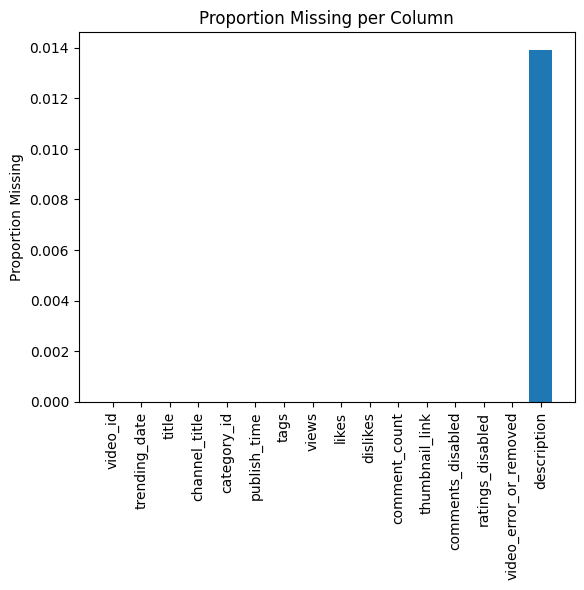

In [ ]:
# Cell 4: Missing-value proportions (simple bar chart)
missing = raw_df.isnull().mean()
plt.bar(missing.index, missing.values)
plt.xticks(rotation=90)
plt.ylabel("Proportion Missing")
plt.title("Proportion Missing per Column")
plt.show()

In [ ]:
# Cell 5: Save data to SQL
engine = create_engine('sqlite:///youtube_trending.db')
raw_df.to_sql('raw_data', con=engine, if_exists='replace', index=False)

conn = sqlite3.connect('youtube_trending.db')
cnt = pd.read_sql_query("SELECT COUNT(*) AS cnt FROM raw_data", conn).iloc[0,0]
print("Rows in raw_data table:", cnt)

Rows in raw_data table: 40949


# **Pipeline 2 - Data Preprocessing**

In [ ]:
# Cell 6: Data cleaning via SQL
c = conn.cursor()
c.execute("""
  CREATE TABLE IF NOT EXISTS cleaned_data AS
  SELECT *
  FROM raw_data
  WHERE views > 0
  AND video_error_or_removed = 0
  AND comments_disabled = 0
""")
conn.commit()

# Compare row counts before and after cleaning
before = pd.read_sql_query("SELECT COUNT(*) AS cnt FROM raw_data", conn).iloc[0,0]
after = pd.read_sql_query("SELECT COUNT(*) AS cnt FROM cleaned_data", conn).iloc[0,0]
print(f"Before cleaning: {before} rows\nAfter cleaning: {after} rows")

# Quick overview of cleaned_data
cleaned_df = pd.read_sql_query("""
  SELECT views, likes, dislikes, comment_count
  FROM cleaned_data
  LIMIT 100
""", conn)
print("Sample of cleaned data:")
display(cleaned_df)

stats = pd.read_sql_query("""
  SELECT
    AVG(views) AS avg_views,
    AVG(likes) AS avg_likes,
    AVG(dislikes) AS avg_dislikes,
    AVG(comment_count) AS avg_comments,
    MIN(views) AS min_views,
    MAX(views) AS max_views
  FROM cleaned_data
""", conn)

pd.set_option('display.float_format', "{:.2f}".format)
print("Summary of cleaned_data:")
display(stats)

Before cleaning: 40949 rows
After cleaning: 40293 rows
Sample of cleaned data:


,views,likes,dislikes,comment_count
0,748374,57527,2966,15954
1,2418783,97185,6146,12703
2,3191434,146033,5339,8181
3,343168,10172,666,2146
4,2095731,132235,1989,17518
...,...,...,...,...
95,836544,40195,373,976
96,284666,16396,81,949
97,3371669,202676,3394,20086
98,195685,14338,171,1070


Summary of cleaned_data:


,avg_views,avg_likes,avg_dislikes,avg_comments,min_views,max_views
0,2358704.80,75111.08,3728.82,8582.86,549,225211923


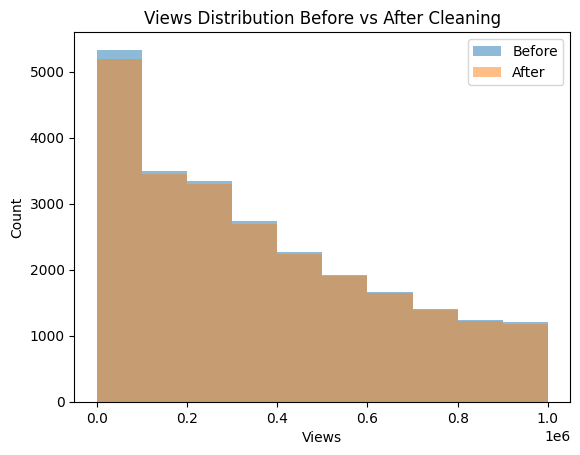

In [ ]:
# Cell 7: Views distribution before vs after cleaning (simple histograms)
before_v = pd.read_sql_query("SELECT views FROM raw_data", conn)['views']
after_v = pd.read_sql_query("SELECT views FROM cleaned_data", conn)['views']

plt.hist(before_v, label='Before', alpha=0.5, range=(0, 1e6))
plt.hist(after_v, label='After', alpha=0.5, range=(0, 1e6))
plt.xlabel("Views")
plt.ylabel("Count")
plt.title("Views Distribution Before vs After Cleaning")
plt.legend()
plt.show()

# **Pipeline 3 - Data Exploration**

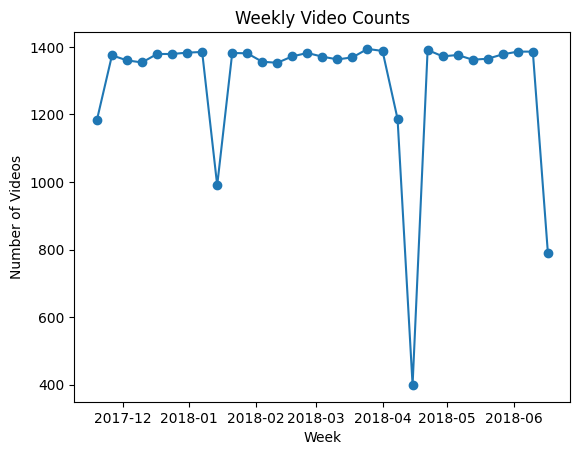

,TrendDate,Count
0,2017-11-14,198
1,2017-11-15,198
2,2017-11-16,197
3,2017-11-17,197
4,2017-11-18,197
...,...,...
200,2018-06-10,198
201,2018-06-11,198
202,2018-06-12,198
203,2018-06-13,197


In [ ]:
# Cell 8: Weekly trending video counts (fix date parsing, simple line plot)
monthly = pd.read_sql_query("""
  SELECT
    date(
      '20' || substr(trending_date, 1, 2) || '-' ||
      substr(trending_date, 7, 2) || '-' ||
      substr(trending_date, 4, 2)
    ) AS TrendDate,
    COUNT(*) AS Count
  FROM cleaned_data
  GROUP BY TrendDate
  ORDER BY TrendDate
""", conn)

monthly['TrendDate'] = pd.to_datetime(monthly['TrendDate'], format='%Y-%m-%d')
weekly_counts = monthly.set_index('TrendDate')['Count'].resample('W').sum()

# Visualize with plot
plt.plot(weekly_counts.index, weekly_counts.values, marker='o')
plt.xlabel("Week")
plt.ylabel("Number of Videos")
plt.title("Weekly Video Counts")
plt.show()

# Display raw daily count data
display(monthly)

# **Pipeline 4 - Feature Engineering**

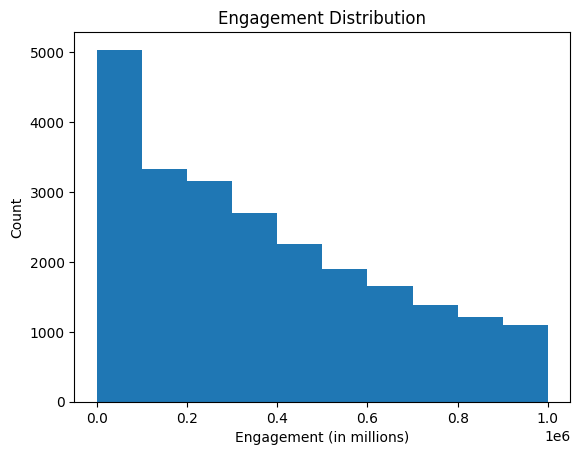

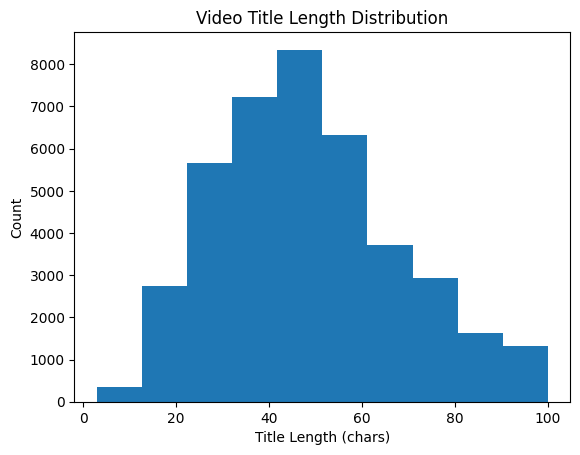

,Engagement,TitleLength
0,821855,34
1,2528671,62
2,3345648,53
3,355486,32
4,2245484,24
...,...,...
40288,1726426,28
40289,1128742,26
40290,1118511,84
40291,5866858,35


In [ ]:
# Cell 9: Feature Engineering - Create & Visualize Basic Features

# Calculate and create new features: total engagement (sum of views + likes + comments) and title length
c.execute("""
  CREATE TABLE IF NOT EXISTS feat_basic AS
  SELECT
    *,
    (views + likes + comment_count) AS Engagement,
    LENGTH(title) AS TitleLength
  FROM cleaned_data
""")
conn.commit()

# Load new features from database
fb = pd.read_sql_query("SELECT Engagement, TitleLength FROM feat_basic", conn)

# Plot engagement distribution
plt.hist(fb['Engagement'], range=(0, 1e6))
plt.title("Engagement Distribution")
plt.xlabel("Engagement (in millions)")
plt.ylabel("Count")
plt.show()

# Plot Title Length distribution
plt.hist(fb['TitleLength'])
plt.title("Video Title Length Distribution")
plt.xlabel("Title Length (chars)")
plt.ylabel("Count")
plt.show()

# Show the table
display(fb)

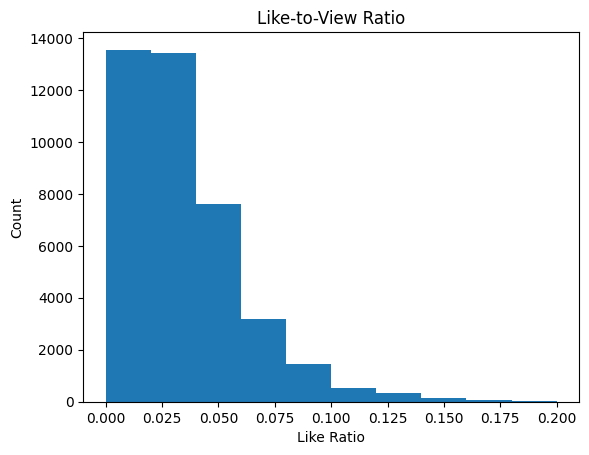

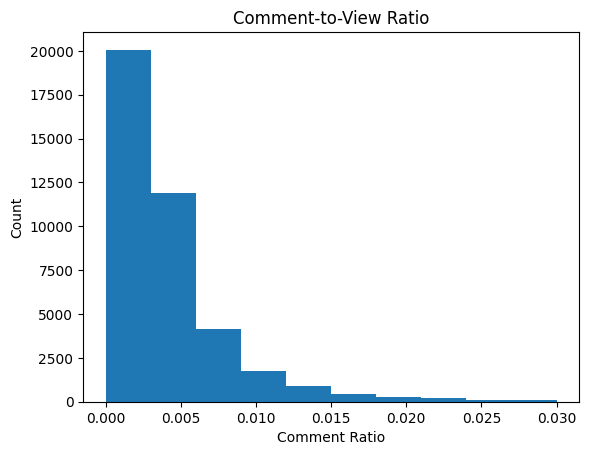

,like_ratio,comment_ratio
0,0.08,0.02
1,0.04,0.01
2,0.05,0.00
3,0.03,0.01
4,0.06,0.01
...,...,...
40288,0.02,0.00
40289,0.06,0.00
40290,0.05,0.00
40291,0.03,0.00


In [ ]:
# Cell 10: Feature Engineering - like-to-view and comment-to-view ratios

# Calculate and create new features: like-to-view and comment-to-view ratios
c.execute("""
  CREATE TABLE IF NOT EXISTS feat_ratios AS
  SELECT *,
    CAST(likes AS FLOAT)/views AS like_ratio,
    CAST(comment_count AS FLOAT)/views AS comment_ratio
  FROM feat_basic
""")
conn.commit()

# Load the new features from database
fr = pd.read_sql_query("SELECT like_ratio, comment_ratio FROM feat_ratios", conn)

# Plot Like Ratio
plt.hist(fr['like_ratio'], range=(0, 0.2))
plt.title("Like-to-View Ratio")
plt.xlabel("Like Ratio")
plt.ylabel("Count")
plt.show()

# Plot Comment Ratio
plt.hist(fr['comment_ratio'], range=(0, 0.03))
plt.title("Comment-to-View Ratio")
plt.xlabel("Comment Ratio")
plt.ylabel("Count")
plt.show()

# Show the table so far
display(fr)

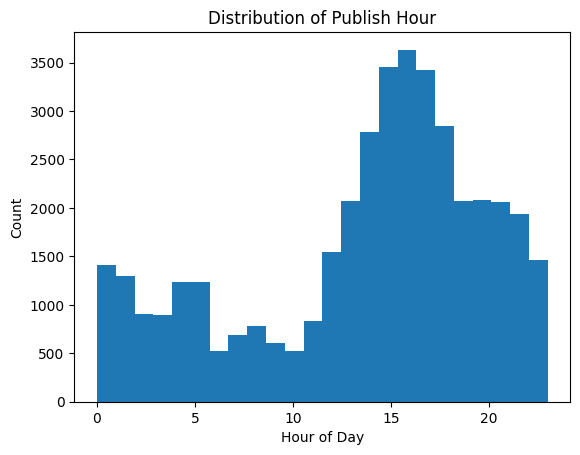

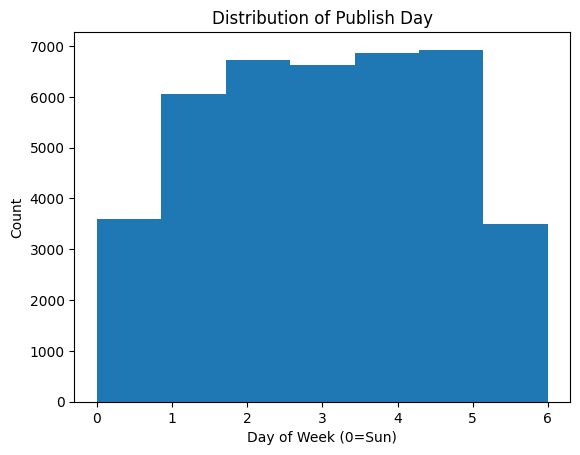

,publish_hour,publish_dayofweek
0,17,1
1,7,1
2,19,0
3,11,1
4,18,0
...,...,...
40288,13,5
40289,1,5
40290,17,5
40291,17,4


In [ ]:
# Cell 11: Feature Engineering - Temporal features

# Calculate and create new features: publish_hour, publish_dayofweek
c.execute("""
  CREATE TABLE IF NOT EXISTS feat_temp AS
  SELECT *,
    CAST(strftime('%H', publish_time) AS INTEGER) AS publish_hour,
    CAST(strftime('%w', publish_time) AS INTEGER) AS publish_dayofweek
  FROM feat_ratios
""")
conn.commit()

# Load the new features from database
ft = pd.read_sql_query("SELECT publish_hour, publish_dayofweek FROM feat_temp", conn)

# Plot Publish Hour
plt.hist(ft['publish_hour'], bins=24)
plt.title("Distribution of Publish Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.show()

# Plot Publish Date of Week
plt.hist(ft['publish_dayofweek'], bins=7)
plt.title("Distribution of Publish Day")
plt.xlabel("Day of Week (0=Sun)")
plt.ylabel("Count")
plt.show()

# Show the table so far
display(ft)

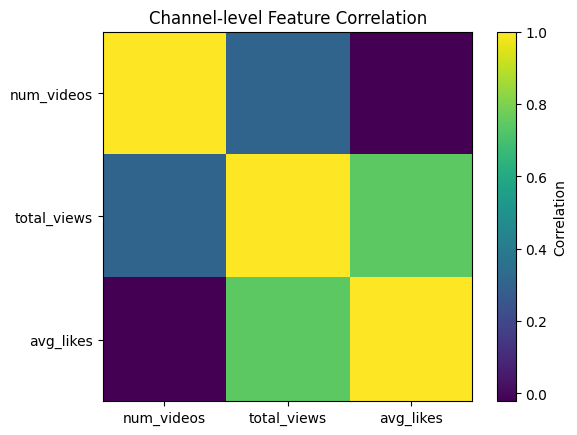

,num_videos,total_views,avg_likes
0,95,232745266,108499.39
1,24,97556377,116435.38
2,74,240999117,175268.62
3,147,142231380,20405.38
4,89,590616191,330282.83
...,...,...,...
40288,65,57641422,24093.48
40289,50,53189544,72969.14
40290,36,28093537,35714.75
40291,3,16880390,192520.67


In [ ]:
# Cell 12: Feature Engineering - Channel aggregates & correlation

# Aggregate metrics by channel
c.execute("""
  CREATE TABLE IF NOT EXISTS channel_agg AS
  SELECT channel_title,
    COUNT(*) AS num_videos,
    SUM(views) AS total_views,
    AVG(likes) AS avg_likes
  FROM feat_temp
  GROUP BY channel_title
""")
conn.commit()

# Join channel-level aggregates back into the main feature table
c.execute("""
  CREATE TABLE IF NOT EXISTS features_final AS
  SELECT t.*, c.num_videos, c.total_views, c.avg_likes
    FROM feat_temp t
  LEFT JOIN channel_agg c ON t.channel_title = c.channel_title
""")
conn.commit()

# Load the new features from database
ff = pd.read_sql_query("SELECT num_videos, total_views, avg_likes FROM features_final", conn)
corr = ff.corr()

# Simple heatmap to check the correlation
plt.imshow(corr)
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Channel-level Feature Correlation")
plt.show()

# Show the table
display(ff)

In [ ]:
# Cell 13: Prepare Data for Engagement-Level Prediction

# Load the engineered feature table
df_feat = pd.read_sql_query("SELECT * FROM features_final", conn)

# Compute median Engagement (views + likes + comments)
median_eng = df_feat['Engagement'].median()
print(f"Median Engagement: {median_eng:.0f}")

# Define binary target: high engagement if above median
df_feat['high_engagement'] = (df_feat['Engagement'] > median_eng).astype(int)

# Select input features
features = ['TitleLength', 'like_ratio', 'comment_ratio', 'publish_hour',
            'publish_dayofweek', 'num_videos', 'total_views', 'avg_likes']

X = df_feat[features]
y = df_feat['high_engagement']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    stratify=y)
print("Train shape: ", X_train.shape, "Test shape:", X_test.shape)

Median Engagement: 706995
Train shape:  (32234, 8) Test shape: (8059, 8)


# **Pipeline 5 - Model Selection**

# **Pipeline 6 - Hyperparameter Tuning**

# **Pipeline 7 - Model Training and Evaluation**

# **Pipeline 8 - Model Deployment**

In [ ]:
# Cell 18: Deploy Model on Gradio

def show_dashboard():
    # Get best RandomForest model
    rf = models['RandomForest']
    gs = GridSearchCV(rf, param_grid['RandomForest'], cv=3, scoring='accuracy', n_jobs=-1)
    gs.fit(X_train, y_train)
    best_model = gs.best_estimator_

    # 1) Title length histogram (same as before)
    fig1, ax1 = plt.subplots(figsize=(6,3))
    for label, val in zip(['Low Engagement', 'High Engagement'], [0, 1]):
        ax1.hist(df_feat.loc[df_feat.high_engagement==val, 'avg_likes'],
                 bins=60, alpha=0.5, label=label)
    ax1.set_xlim(0, 1e6)
    ax1.set_xlabel("Average Likes")
    ax1.set_ylabel("Count")
    ax1.set_title("Average Likes by Engagement Class")
    ax1.legend()
    fig1.tight_layout()

    # 2) Tuned model accuracies (same as before)
    fig2, ax2 = plt.subplots(figsize=(6,3))
    names, accs = zip(*tuned_acc.items())
    ax2.bar(names, accs, color='lightgreen')
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Tuned Model Accuracies")
    fig2.tight_layout()

    # 3) Feature importances
    importances = pd.Series(best_model.feature_importances_, index=features).sort_values()
    fig3, ax3 = plt.subplots(figsize=(6,3))
    importances.plot.barh(ax=ax3)
    ax3.set_title("RandomForest Feature Importances")
    fig3.tight_layout()

    return fig1, fig2, fig3

# Launch Gradio interface
gr.Interface(
    fn=show_dashboard,
    inputs=[],
    outputs=[
        gr.Plot(label="Average Likes by Engagement Class"),
        gr.Plot(label="Tuned Model Accuracies"),
        gr.Plot(label="Feature Importances")
    ],
    title="US YouTube Video Engagement Dashboard & Model Insights"
).launch()
